In [2]:
import numpy as np
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt

In [3]:
def hilbert_curve(n):
    def rot(s, x, y, rx, ry):
        if ry == 0:
            if rx == 1:
                x = s - 1 - x
                y = s - 1 - y
            x, y = y, x
        return x, y

    N = 2 ** n
    coords = []
    for d in range(N * N):
        x = y = 0
        t = d
        s = 1
        while s < N:
            rx = 1 & (t // 2)
            ry = 1 & (t ^ rx)
            x, y = rot(s, x, y, rx, ry)
            x += s * rx
            y += s * ry
            t //= 4
            s *= 2
        coords.append((x, y))
    return coords, N

def upscale_path(path, scale):
    size = (max(x for x, y in path)+1) * scale
    maze = np.ones((size, size), dtype=np.uint8)

    for i in range(len(path) - 1):
        x1, y1 = path[i]
        x2, y2 = path[i+1]

        x1 *= scale
        y1 *= scale
        x2 *= scale
        y2 *= scale

        # Draw line between x1,y1 and x2,y2
        rr, cc = draw_line(x1, y1, x2, y2)
        maze[rr, cc] = 0  # carve path

    return maze

def draw_line(x1, y1, x2, y2):
    """Simple Bresenham's line algorithm for integer grid drawing"""
    from skimage.draw import line
    return line(y1, x1, y2, x2)


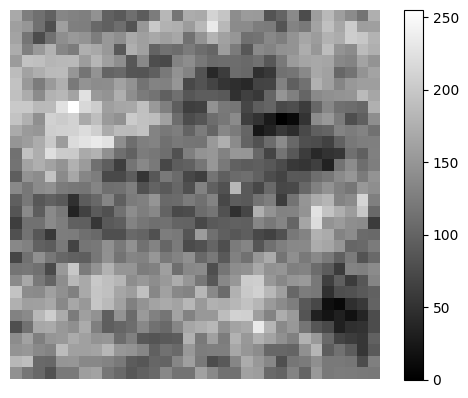

In [4]:
def generate_pink_noise_image(size):
    # Create white noise
    white = np.random.normal(size=(size, size))

    # Fourier transform
    f_transform = fftshift(fft2(white))

    # Create frequency grid
    y, x = np.indices((size, size)) - size // 2
    radius = np.sqrt(x**2 + y**2)
    radius[radius == 0] = 1  # avoid division by zero

    # Apply 1/f filter
    pink_filter = 1 / radius
    pink_transform = f_transform * pink_filter

    # Inverse Fourier transform
    pink_noise = np.real(ifft2(ifftshift(pink_transform)))

    # Normalize to 0–255 grayscale
    pink_noise -= pink_noise.min()
    pink_noise /= pink_noise.max()
    pink_noise *= 255

    return pink_noise.astype(np.uint8)

# Generate and display (test)
image = generate_pink_noise_image(32)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.show()


In [5]:
# Generate Hilbert curve path
order = 4
scale = 2  # Makes walls visible
path, _ = hilbert_curve(order)
maze = upscale_path(path, scale)

# Invert maze
maze = 1 - maze

In [6]:
whiteNoiseScale = 2
pintNoiseScale = 1

# Save the maze as a mask
mazeMask = maze.copy()

# Generate white noise
whiteNoise = np.random.normal(0, whiteNoiseScale, maze.shape) 

# Generate pink noise
pinkNoise = generate_pink_noise_image(maze.shape[0])

# Scale both noise maps to 0-1
whiteNoise = (whiteNoise - whiteNoise.min()) / (whiteNoise.max() - whiteNoise.min())
pinkNoise = (pinkNoise - pinkNoise.min()) / (pinkNoise.max() - pinkNoise.min())

# Apply noise to the the maze
maze = maze + whiteNoise * whiteNoiseScale + pinkNoise * pintNoiseScale

# Apply the mask to remove the noise from the 0 values
maze = maze * mazeMask

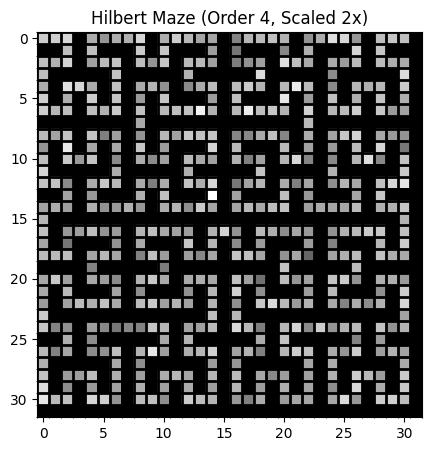

(32, 32)
[[2.78732136 2.82306621 2.92745206 0.         2.34196789 2.0281208
  2.3761073  2.39328195 2.91476047 0.        ]
 [0.         0.         2.59193171 0.         2.59304697 0.
  0.         0.         2.74168146 0.        ]
 [2.60565997 2.39670937 2.87672916 0.         2.1826233  2.52965898
  2.67089423 0.         2.58127261 2.02456192]
 [2.6018184  0.         0.         0.         0.         0.
  2.67624935 0.         0.         0.        ]
 [2.35708659 0.         3.0540231  2.9175934  2.33166549 0.
  2.60991609 0.         2.31011384 2.44337158]
 [2.8028851  0.         2.35310618 0.         2.77962863 0.
  2.66897802 0.         2.10188551 0.        ]
 [2.79068684 2.47352708 2.57771993 0.         2.5907093  2.41692006
  2.72816956 0.         2.60449822 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         2.30527652 0.        ]
 [2.52765157 2.22211336 2.63717339 0.         2.65073247 1.73222658
  2.18340665 0.         1.99748529 0.       

In [7]:

plt.figure(figsize=(5, 5))
plt.imshow(maze, cmap='gray', interpolation='nearest')

# Add grid lines to outline each pixel
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, maze.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, maze.shape[0], 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
ax.tick_params(which='minor', size=1)

plt.title(f"Hilbert Maze (Order {order}, Scaled {scale}x)")
plt.show()


print(np.shape(maze))
print(maze[:10, :10])


(32, 32)


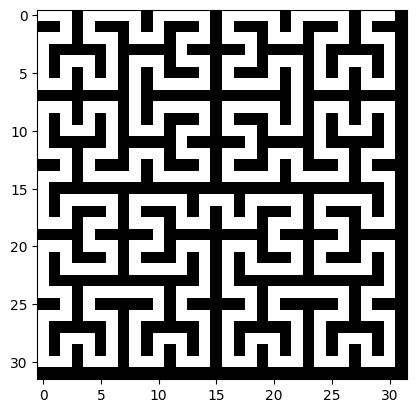

In [12]:
# Generate Hilbert curve path
order = 4
scale = 2  # Makes walls visible
path, _ = hilbert_curve(order)
maze = upscale_path(path, scale)

# Invert maze
maze = 1 - maze

print(np.shape(maze))

np.savetxt("maze.csv", maze, delimiter=",", fmt='%d')

plt.imshow(maze, cmap='gray', interpolation='nearest')
plt.show()